経路の最適化

実験1

開始点(0,0),終了点(5,0)

中間点5点

評価関数　経路の距離、セグメントのなす角度の和

制約　中間点が障害物外

障害物　4点(1,0),(1,4),(4,4),(4,0)

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

In [2]:
#評価関数
#J1：経路の距離
def evalation1(path_list):
    total_distance = 0
    for i in range(len(path_list) - 1):
        segment_distance = ((path_list[i][0] - path_list[i+1][0])**2 + (path_list[i][1] - path_list[i+1][1])**2)**(1/2)
        total_distance += segment_distance
    return total_distance

In [11]:
#評価関数
#J2：セグメントのなす角の2乗和
def evalation2(path_list):
    total_segment_inner_product = 0
    for i in range(len(path_list)-2):
        #セグメントの距離
        segment_distance1 = ((path_list[i][0] - path_list[i+1][0])**2 + (path_list[i][1] - path_list[i+1][1])**2)**(1/2)
        segment_distance2 = ((path_list[i+1][0] - path_list[i+2][0])**2 + (path_list[i+1][1] - path_list[i+2][1])**2)**(1/2)

        #セグメントのベクトル
        segment_vecter1 = [path_list[i+1][0] - path_list[i][0], path_list[i+1][1] - path_list[i][1]]
        segment_vecter2 = [path_list[i+2][0] - path_list[i+1][0], path_list[i+2][1] - path_list[i+1][1]]

        #セグメントの内積
        segment_inner_product = (segment_vecter1[0] * segment_vecter2[0] + segment_vecter1[1] * segment_vecter2[1])/(segment_distance1 * segment_distance2)

        total_segment_inner_product += (1 - segment_inner_product) ** 2

    return total_segment_inner_product


In [12]:
#全体の評価関数
#J：J1とJ2の重み付き線形和
def total_evaluation(path_list, w1, w2):
    J1 = evalation1(path_list)
    J2 = evalation2(path_list)
    
    J_total = w1 * J1 + w2 * J2
    
    return J_total, J1, J2

In [13]:
#数値微分により勾配を求める
def dif_total_evaluation(path_list, w1, w2, h = 0.001):
    result = []
    for i in range(len(path_list)):
        #開始点、終点は設計変数ではないため0を返し、勾配を計算しない
        if i == 0 or i == len(path_list) - 1:
            result.append([0, 0])
        else:
            delta_path_list = copy.deepcopy(path_list)
            delta_path_list[i][0] += h
            dif_x_total_evaluation = (total_evaluation(delta_path_list, w1, w2)[0] - total_evaluation(path_list, w1, w2)[0])/h
            
            delta_path_list = copy.deepcopy(path_list)
            delta_path_list[i][1] += h
            dif_y_total_evaluation = (total_evaluation(delta_path_list, w1, w2)[0] - total_evaluation(path_list, w1, w2)[0])/h

            result.append([dif_x_total_evaluation, dif_y_total_evaluation])
    
    return result


In [14]:
#衝突判定
#各点が障害物の領域外であれば、Trueを返す

def check_collision(path_list, obstacle_list):
    flag = True
    for i in range(len(path_list)):
        x = path_list[i][0]
        y = path_list[i][1]
        
        for j in range(len(obstacle_list)):
            if x > obstacle_list[j][0][0] and x < obstacle_list[j][1][0] and y > obstacle_list[j][0][1] and y < obstacle_list[j][1][1]:
                flag = False
            else:
                continue
    return flag

In [15]:
#グラフによる可視化
def vis_path(path_list, obstacle_list):
    fig , ax = plt.subplots()
    
    #障害物の配置
    for i in range(len(obstacle_list)):
        #widthとheightの計算
        width = obstacle_list[i][1][0] - obstacle_list[i][0][0]
        height = obstacle_list[i][1][1] - obstacle_list[i][0][1]
        
        obstacle = patches.Rectangle(xy = tuple(obstacle_list[i][0]), width = width, height = height, fc = "black", ec = "black")
        ax.add_patch(obstacle)
        
    #path_listからx,yのlistを作成
    x = []
    y = []
    for i in range(len(path_list)):
        x.append(path_list[i][0])
        y.append(path_list[i][1])
        
    #pathをplot
    ax.plot(x, y, linestyle = "solid", marker="o", color = "black")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    #グラフの表示
    plt.show()
    
#pathの最適化過程を画像で出力
def process_path(path_history, obstacle_list):
    fig , ax = plt.subplots()
    
    #障害物の配置
    for i in range(len(obstacle_list)):
        #widthとheightの計算
        width = obstacle_list[i][1][0] - obstacle_list[i][0][0]
        height = obstacle_list[i][1][1] - obstacle_list[i][0][1]
        
        obstacle = patches.Rectangle(xy = tuple(obstacle_list[i][0]), width = width, height = height, fc = "black", ec = "black")
        ax.add_patch(obstacle)
        
    #履歴の数を取得
    length_history = len(path_history)
    
    #約10回分のpathを抽出する
    if length_history // 10 == 0:
        output_path = path_history
    else:
        output_history = []
        for i in range(10):
            num = i * (length_history // 10)
            output_history.append(path_history[num])
        #最終結果もappend
        output_history.append(path_history[-1])
    
    #グラフに描写
    for j in range(len(output_history)):
        #output_history[i]からx,yのlistを作成
        x = []
        y = []
        for i in range(len(output_history[j])):
            x.append(output_history[j][i][0])
            y.append(output_history[j][i][1])
            
        #pathをplot(初期値は青、最終結果は赤で描画)
        if j == len(output_history) - 1:
            ax.plot(x, y, linestyle = "solid", marker="o", color = "red", label = "optimized path")
        elif j == 0:
            ax.plot(x, y, linestyle = "solid", marker="o", color = "blue", label = "initial path")
        else:
            ax.plot(x, y, linestyle = "solid", marker="o", color = "black")
            
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.legend(loc='lower right')
    #グラフの表示
    plt.show()
    
#評価関数の可視化
def vis_evaluation(J_total_list, J1_list, J2_list):
    iteration_list = list(range(len(J_total_list)))
    
    fig , ax = plt.subplots()
    ax.plot(iteration_list, J_total_list, color = "red", label = "total")
    ax.plot(iteration_list, J1_list, color = "blue", label = "distance")
    ax.plot(iteration_list, J2_list, color = "green", label = "curvature")
    
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Evaluation")
    plt.legend(loc='lower right')
    
    #グラフの表示
    plt.show()
    

In [16]:
#最適化を行うmain関数
def main(path_list, obstacle_list, w1, w2, alpha, iteration):
    #pathを保存するlistの準備
    global path_history 
    path_history = [path_list]
    
    #評価関数の値を保存するlistの準備
    global J_total_list, J1_list, J2_list
    J_total_list, J1_list, J2_list = [], [], []
    
    #iterationだけ反復を繰り返す
    for i in range(iteration):
        #グラフの可視化
        #vis_path(path_list, obstacle_list)
        
        #評価関数の計算
        J_total, J1, J2 = total_evaluation(path_list, w1, w2)
        
        #勾配の計算
        delta = dif_total_evaluation(path_list, w1, w2, h = 0.001)
        
        #listをnumpyに変換
        path_list = np.array(path_list)
        delta = np.array(delta)
        
        #更新
        path_list = path_list - alpha * delta
        
        #numpyをlistに戻す
        path_list = path_list.tolist()
        delta = delta.tolist()
        
        #衝突判定(衝突がなければ続行、衝突すれば最適化終了)
        flag = check_collision(path_list, obstacle_list)
        if flag == True:
            #更新したpathをに保存
            path_history.append(path_list)
            
            #評価関数の値をlistに保存
            J_total_list.append(J_total)
            J1_list.append(J1)
            J2_list.append(J2)
            continue
        else:
            print("衝突発生")
            print("反復回数：", i)
            break
    
    #グラフの可視化
    process_path(path_history, obstacle_list)
    vis_evaluation(J_total_list, J1_list, J2_list)
        

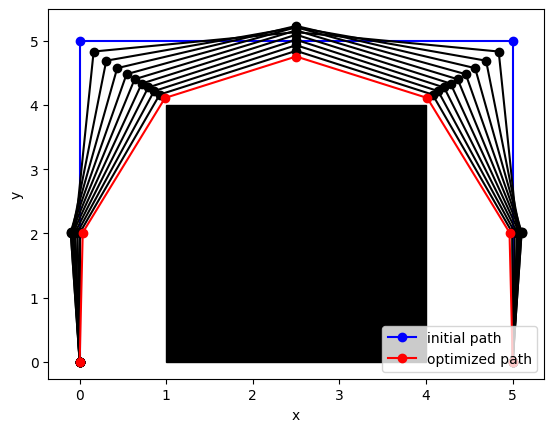

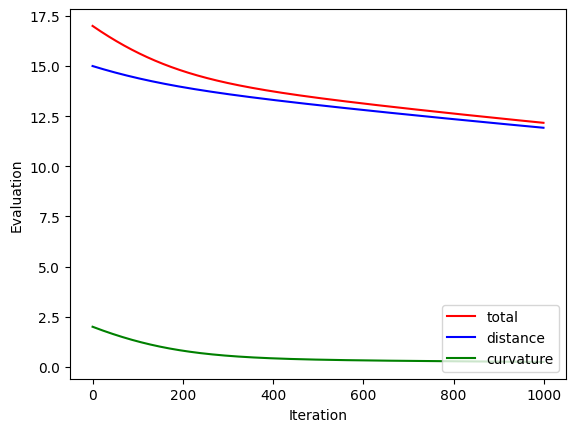

In [17]:
#開始点、終点を含む点列のリスト
path_list = [[0, 0], [0, 2], [0, 5], [2.5, 5], [5, 5], [5, 2], [5, 0]]

#障害物のリスト[(左下の座標),(右上の座標)]
obstacle_list = [[(1, 0), (4, 4)]]

main(path_list, obstacle_list, 1, 1, 0.001, 1000)

[0]
